In [1]:
%matplotlib inline

import math

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import plotly
import plotly.figure_factory as ff


# Simulate Data

In [2]:
import importlib
import simulate_data
importlib.reload(simulate_data)

<module 'simulate_data' from '/Users/hwunrow/Documents/GitHub/rt-estimation/src/simulate_data.py'>

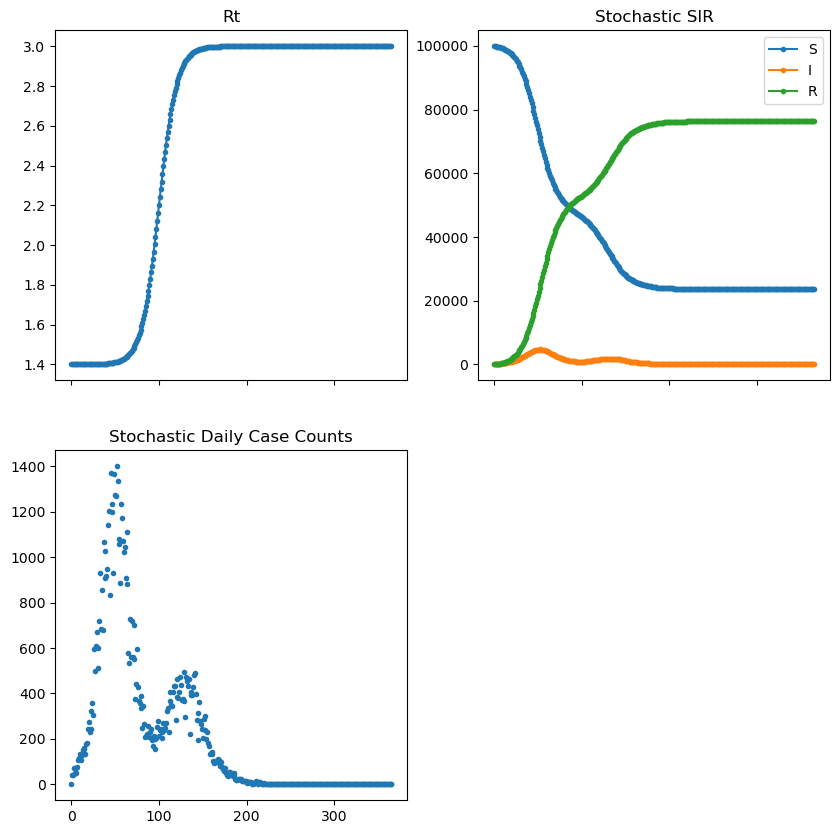

In [3]:
true_params = {
    'rt_0': 1.4,
    'rt_1': 3.,
    'midpoint': 100.,
    'k': 0.1,
    'n_t': 365,
    't_I': 4.,
    'N': 100_000.,
    'S0': 99_900.,
    'I0': 100.,
}


np.random.seed(1994)

# data = simulate_data.simulate_data(**true_params, run_deterministic=True)

data = simulate_data.simulate_data(**true_params, add_noise=True, noise_param=1/50)

data.plot_all()

# Adaptive Inflation
Based on JL Anderson (2008)

In [38]:
import collections

SIR = collections.namedtuple(
  typename='SIRComponents',
  field_names=[
    'S',              # S
    'I',               # I
    'R',                # R
    'i'])

ModelParams = collections.namedtuple(
    typename='ModelParams',
    field_names=[
      'beta',                        # Beta
      't_I'   # t_I = 1/gamma
    ]
)

beta = data.construct_beta(data.rt, data.t_I)

x = SIR(
    S = data.S0,
    I = data.I0,
    R = 0,
    i = 0
)
θ = ModelParams(beta, data.t_I)

In [39]:
def f(t, x, θ, N, dt=1, noise_param=1/25):
    """
    State transition function.
        Args:
            t: time
            x: state space
            θ: parameters
            N: population
            dt: time step in days
    """

    # Stochastic transitions
    dSI = np.random.poisson(x.S * x.I/ N * θ.beta) # susceptible to infected
    dIR = np.random.poisson(x.I / θ.t_I) # infected to recovered
    
    # OEV = np.maximum(1., dSI**2 * noise_param)
    # OEV_sample= np.random.normal(0, 1, size=len(dSI))
    # i_noise = dSI + OEV_sample * np.sqrt(OEV)

    # Updates
    x_new = SIR(
        S = np.clip(x.S - dSI, 0, N),
        I = np.clip(x.I + dSI - dIR, 0, N),
        R = np.clip(x.R + dIR, 0, N),
        i = np.clip(dSI, 0, N)
    )

    return x_new

def g(x, α):
    """
    Observational function.
        Args:
            x: state space
            α: report rate
    """
    # y = np.random.binomial(x.i.astype(int), α)
    return x.i

def f0(pop, m=300):
    """
    Initial guess of the state space.
        Args:
            pop: population
            m: number of ensemble members
    """
#     I0 = pop * inf_init
#     S0 = pop - I0
#     R0 = 0
#     i = 0

    S0 = np.random.uniform(pop*0.8, pop, size=m)
    I0 = pop - S0
    R0 = np.zeros(m)
    i0 = np.zeros(m)
    
    x0 = SIR(
        S = S0,
        I = I0,
        R = R0,
        i = i0
    )
    return x0

def θ0(prior, m=300):
    """
    Initial guess of the parameter space.
        Args:
            prior: prior
            m: number of ensemble members
    """
    beta = prior['beta']['dist'](**prior['beta']['args'], size=m)
    θ0 = ModelParams(beta=beta, t_I=np.ones(m)*data.t_I)
    return θ0

In [40]:
def eakf(x, y, z, oev, m=300):
    """
    Args:
        x: latenet state rv or latent parameter rv
        y: observed rv
        z: observation
        oev: observational error variance
    """
    x = np.array(x)
    y = np.array(y)
    
    p, m = x.shape

    mu_prior  = y.mean()
    var_prior = y.var()

    # degenerate prior.
    var_prior = np.where(var_prior == 0., 1e-3, var_prior)

    var_post = var_prior * oev / (var_prior + oev)
    mu_post  = var_post  * (mu_prior/var_prior + z/oev)
    alpha    = (oev / (oev + var_prior)) ** (0.5)
    dy       = (mu_post - y) + alpha * (y - mu_prior)
    
    # compute covariance
    rr = np.full((p, 1), np.nan)

    # import pdb; pdb.set_trace()
    for ip in range(p):
        A  = np.cov(x[ip, :], y)
        rr[ip,:] =  A[1, 0] / var_prior
    dx = np.dot(rr, dy.reshape((1,m)))
    # rr = np.cov(x, y)[:-1,-1] / var_prior
    # dx_new = np.dot(rr.reshape((4,1)), dy.reshape((1,300)))

    xpost = x + dx
    ypost = y + dy

    return xpost, ypost

In [41]:
from numpy.random import uniform

prior = {
    'beta':{
        'dist': uniform,
        'args':{
            'low': 0.1,
            'high': 2.,
        }
    },
    't_I':{
        'dist': "constant",
        # 'args':{
        #     'lower': 1.,
        #     'upper': 12.,
        # }
    },
}



In [170]:
from tqdm import tqdm

x_list = []
θ_list = []
lam_list = []

m = 300

for t, date in enumerate(range(data.n_t)):
    if t == 0:
        x = f0(data.N, m=m)
        θ = θ0(prior, m=m)
    else:
        x = f(t, x, θ, data.N)  # prediction
        y = g(x, α=1)           # analysis
        z = data.i[t]
        
        def _adaptive_inflation(x, y, z, oev, lambar_prior=1.01, siglam2=0.1):
            # step 3b
            sig2p = np.var(y)
            ybarp = np.mean(y)
            D = np.abs(ybarp - z)*z/50

            # step 3c
            r = np.cov(x, y)[0,1]  # i
            lam0 = (1. + r*(np.sqrt(lambar_prior) - 1.))**2  # iii
            theta = np.sqrt(lam0 * sig2p + oev)  #iv
            
            
            # v/ Appendix A
            lbar = 1./(np.sqrt(2*np.pi) * theta) * np.exp(-D**2/(2.*theta**2))
            dthetadlam = sig2p * r * (1. - r + r*np.sqrt(lambar_prior))/(2.*theta*np.sqrt(lambar_prior))
            lprime = lbar *(D**2/theta**2 -1.)/theta * dthetadlam
            
            b = lbar/lprime - 2*lambar_prior
            c = lambar_prior**2 - siglam2 - lbar * lambar_prior/lprime
            
            lam1 = np.abs((-b + np.sqrt(b**2 - 4.*c))/2)
            lam2 = np.abs((-b - np.sqrt(b**2 - 4.*c))/2)
            
            if np.abs(lam1 - lambar_prior) < np.abs(lam2 - lambar_prior):
                return lam1
            else:
                return lam2
        
        def _inflate_ensembles(ens, inflation_value, params=False):
            if params:
                _, m = np.asarray(ens).shape
                ens_mean = np.mean(ens, 1, keepdims=True)
                ens_inflated = ens_mean * np.ones((1,m)) + inflation_value*(ens - ens_mean*np.ones((1,m)))
            else:
                m = len(ens)
                ens_mean = np.mean(ens)
                ens_inflated = ens_mean * np.ones(m) + inflation_value*(ens - ens_mean*np.ones(m))

            return ens_inflated
        
        
        oev = np.maximum(10, z**2/50)
        if t > 50:
            lam = _adaptive_inflation(θ.beta, y, z, oev)
            lam_list.append(lam)
            θ = _inflate_ensembles(θ, inflation_value=lam, params=True)
            θ = np.clip(θ, 0, 10)
            θ = ModelParams(*θ)
        
#             lam_S = _adaptive_inflation(x.S, y, z, oev)
#             lam_I = _adaptive_inflation(x.I, y, z, oev)
#             lam_R = _adaptive_inflation(x.R, y, z, oev)
#             # print(lam_S, lam_I, lam_R)
#             S = _inflate_ensembles(x.S, inflation_value=lam_S)
#             I = _inflate_ensembles(x.I, inflation_value=lam_I)
#             R = _inflate_ensembles(x.R, inflation_value=lam_R)

#             x = SIR(
#                 S = np.clip(S, 0, data.N),
#                 I = np.clip(I, 0, data.N),
#                 R = np.clip(R, 0, data.N),
#                 i = np.clip(x.i, 0, data.N)
#             )
        
        x, new_i = eakf(x, y, z, oev=oev)
        x = SIR(*x)
        x = x._replace(i=new_i)
        x = SIR(
            S = np.clip(x.S, 0, data.N),
            I = np.clip(x.I, 0, data.N),
            R = np.clip(x.R, 0, data.N),
            i = np.clip(x.i, 0, data.N)
        )
        θ, _ = eakf(θ, y, z, oev=oev, m=m)
        θ = np.clip(θ, 0, None)
        θ = ModelParams(*θ)
    
    x_list.append(x)
    θ_list.append(θ)

Text(0.5, 0.98, 'EAKF full time series no inflation')

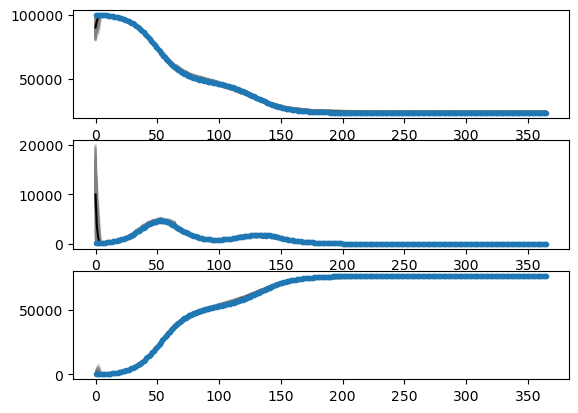

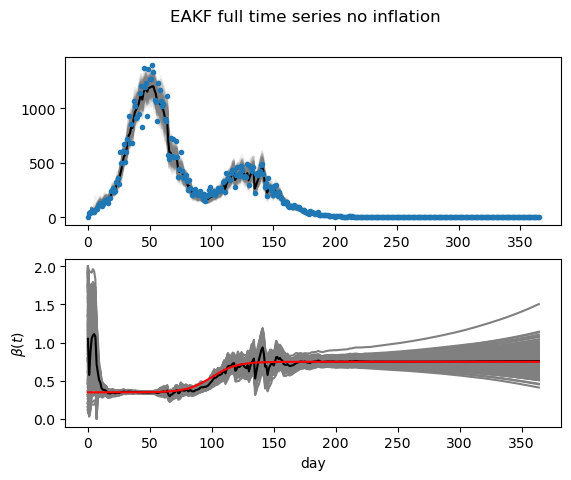

In [171]:
fig, ax = plt.subplots(3)
ax[0].plot([x.S for x in x_list], color='gray', alpha=0.1)
ax[0].plot(np.mean([x.S for x in x_list], axis=1), color='black')
ax[0].plot(data.S, '.')

ax[1].plot([x.I for x in x_list], color='gray', alpha=0.1)
ax[1].plot(np.mean([x.I for x in x_list], axis=1), color='black')
ax[1].plot(data.I, '.')

ax[2].plot([x.R for x in x_list], color='gray', alpha=0.1)
ax[2].plot(np.mean([x.R for x in x_list], axis=1), color='black')
ax[2].plot(data.R, '.')

fig, ax = plt.subplots(2)
ax[0].plot([x.i for x in x_list], color='gray', alpha=0.1)
ax[0].plot(np.mean([x.i for x in x_list], axis=1), color='black')
ax[0].plot(data.i, '.')

ax[1].plot([θ.beta for θ in θ_list], color="gray")
ax[1].plot(np.mean([θ.beta for θ in θ_list], axis=1), color="black")
ax[1].plot(beta, color="red")
ax[1].set_xlabel('day')
ax[1].set_ylabel(r'$\beta(t)$')

fig.suptitle('EAKF full time series no inflation')

In [183]:
data.i[150:]

array([2.04634596e+02, 2.86754159e+02, 3.00229217e+02, 2.37476989e+02,
       2.00592454e+02, 2.29524195e+02, 1.81735417e+02, 1.69952697e+02,
       1.33011622e+02, 1.38844520e+02, 1.32415064e+02, 1.41587173e+02,
       1.03406400e+02, 9.40854503e+01, 1.04155288e+02, 9.85094830e+01,
       9.62945259e+01, 1.12313124e+02, 1.07937879e+02, 9.36450913e+01,
       8.24372201e+01, 9.64990180e+01, 7.81339635e+01, 6.59549695e+01,
       5.87808218e+01, 7.27263208e+01, 4.85867568e+01, 3.97422353e+01,
       4.94881435e+01, 3.58176069e+01, 5.49491861e+01, 5.26840799e+01,
       4.19269907e+01, 4.54385749e+01, 3.54865604e+01, 4.31925148e+01,
       4.78248923e+01, 2.52705796e+01, 2.03378009e+01, 1.95807370e+01,
       2.34784550e+01, 2.33443545e+01, 2.43787208e+01, 2.39882586e+01,
       2.04454576e+01, 1.39909083e+01, 1.53676178e+01, 1.45897286e+01,
       1.34725806e+01, 1.27676826e+01, 7.44145282e+00, 1.02664531e+01,
       1.07662097e+01, 1.03849241e+01, 1.16260281e+01, 9.50764241e+00,
      

In [174]:
post_i = np.array([x.i for x in x_list])
innovation = np.abs(post_i - np.array([data.i[:-1]]).T)
# plt.plot(innovation)


Text(0, 0.5, '$\\beta(t)$')

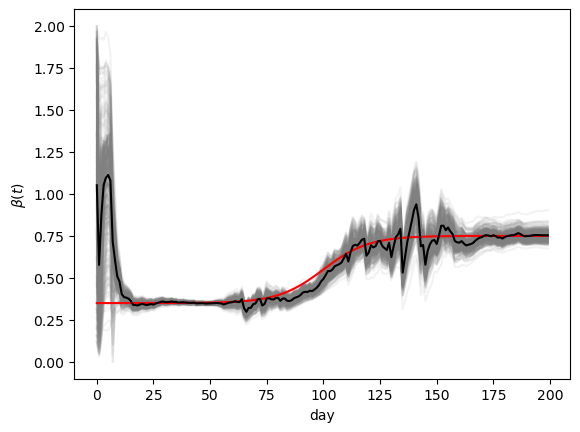

In [175]:
fig, ax = plt.subplots()
tt = np.arange(0, 200)
ens = np.array([θ.beta for θ in θ_list])
ax.plot(tt, ens[0:200,:], color="gray", alpha=0.1)
ax.plot(tt, data.construct_beta(data.rt, data.t_I)[0:200], color="red")
ax.plot(tt, np.mean([θ.beta for θ in θ_list], axis=1)[0:200], color="black")
ax.set_xlabel('day')
ax.set_ylabel(r'$\beta(t)$')

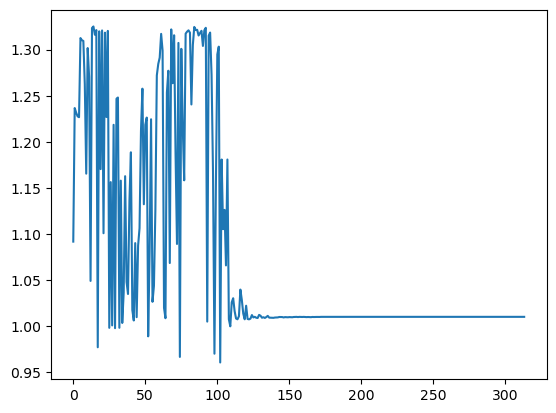

In [176]:
plt.plot(lam_list)

In [181]:
np.mean(lam_list[150:])

1.0099709717535055

In [177]:
post_beta = np.array([θ.beta for θ in θ_list])

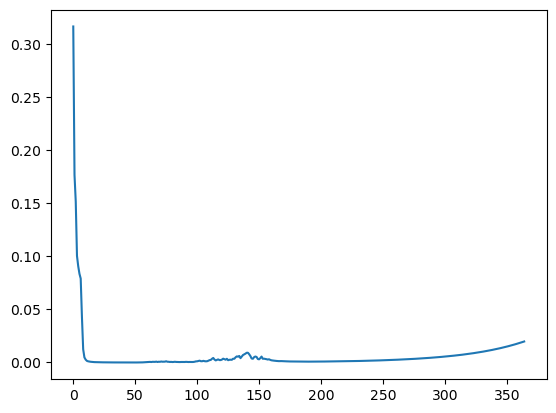

In [179]:
plt.plot(np.var(post_beta, axis=1))

In [152]:
np.mean(lam_list[200:])

nan